# Benchmark M3.2: Water flow in roots - Static root system

by Daniel Leitner, Andrea Schnepf 

In this benchmark, we extend benchmark M3.1 from a single root to a root system. We consider water flow inside a small static root system of a lupine plant which was grown for 14 days in a soil-filled column of 20 cm depth and 7 cm diameter. The root system was imaged by MRI at Forschungszentrum Jülich; the resulting root grid is provided in RSML, DGF and RootSys formats in the folder "root_grid/RootSystem.rsml". 

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from rsml import * 
from van_genuchten import *

## Theory


In this module, we consider water flow in xylem with the soil water potential considered static. The derivation of this problem is based on Roose and Fowler (2004) and Doussan et al. (2006).


The axial water flux in a xylem is given by 
\begin{eqnarray} 
q_z = - k_z \left( \frac{\partial \psi_r}{\partial z} - e_z \cdot v \right), \label{axialflux}
\end{eqnarray}
with units [cm$^3$ day$^{-1}$], see Eqn 3.1 Roose and Fowler, 2004. 
The parameter $k_z$ is the axial conductance [cm$^3$ day$^{-1}$], 
$\psi_r$ is the pressure inside the xylem [cm], 
$e_z$ the downward unit vector [1],
and $v$ the normed direction of the xylem [1]. Thus Eqn \ref{axialflux} can be expressed as
\begin{eqnarray}
q_z = - k_z \left( \frac{\partial \psi_r}{\partial z} + v_3 \right), \label{axialflux2}
\end{eqnarray}
where $v_3$ is the $z$-component of the normed xylem direction. \\

\noindent
The radial flux is given by 
\begin{eqnarray}
q_r = - 2 a \pi l k_r (\psi_s - \psi_r),
\end{eqnarray}
with units [cm$^3$ day$^{-1}$] (based on Eqn 3.3 Roose and Fowler, 2004), 
where $a$ is the root radius [cm], 
$l$ is the segments length [cm], 
$k_r$ is the radial conductance [day$^{-1}$], 
and $\psi_s$ is the soil matric potential of the surrounding soil [cm]. \\

\noindent
The net flux is given by
\begin{eqnarray}
q = q_z + q_r,
\end{eqnarray} 
and mass conservation yields
\begin{eqnarray}
2 a \pi k_r (\psi_s - \psi_r) = - k_z \frac{\partial^2 \psi_r}{\partial z^2} \label{masscons}
\end{eqnarray}
(see Eqn 3.4 Roose and Fowler, 2004).

\noindent
For discretisation we use first Kirchhoff's law: In a graph that represents the root system for each node $i$ the sum of fluxes must be zero 
\begin{eqnarray}
\sum_{j \in N(i)} q_{ij} = 0,  \label{KH}
\end{eqnarray}
where $N(i)$ are the nodes that are connected to node $i$ and $q_{ij}$ is the net flux of the edge connecting node $i$ and node $j$.


##  Description of benchmark M3.2

We first open the root system grid. Note that RSML properties are given by root (i.e. one value for each polyline), while RSML functions are given per node (i.e. for each node of the polylines).

In [3]:
polylines, props, funcs = read_rsml("root_grid/RootSystem.rsml")
print("Properties:") # one per root
for key, v in props.items() :
    print("\t", key)
print("Functions:") # oner per root node
for key, v in funcs.items() :
    print("\t", key)

Properties:
	 parent-poly
	 parent-node
Functions:
	 emergence_time
	 diameter
	 type


We visualize this small root system by the following script, where colors denote the node emergence time.

<Figure size 432x288 with 0 Axes>

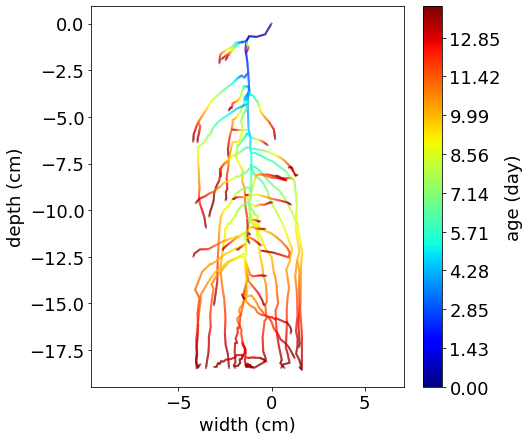

In [4]:
et_ = funcs["emergence_time"]

cmap = plt.get_cmap("jet", 256)
cb = plt.contourf([[0,0],[0,0]], np.linspace(0, 14, 256), cmap=cmap) # Using contourf to provide a colorbar info

plt.clf()
plt.figure(figsize=(7,7))

for i, pl in enumerate(polylines):
    for j in range(0, len(pl)-1):        
        n1, n2, et = pl[j], pl[j+1], et_[i][j+1]
        plt.plot([n1[1], n2[1]], [n1[2], n2[2]], color = cmap(et/14), linewidth = 2, alpha = 0.5)  # y,z plot
        
plt.axis('equal')
plt.xlabel("width (cm)")
plt.ylabel("depth (cm)")
cb1 = plt.colorbar(cb)
cb1.set_label('age (day)')
plt.savefig('m32_rootsystem.png', dpi=300, bbox_inches = "tight")
plt.show()

For benchmark M3.2(a) we first neglect root age and define static conductivities according to Javaux et al. (2008), and define boundary conditions as in Benchmark M3.1: At the root collar we assume a pressure of -500 cm located at node index 0, and a no-flux boundary condition at the root tips. The soil is assumed to be static with a matric potential of -200 cm. 

Aim is to calculate the pressure at the nodes.

In [5]:
kx = 4.32e-2      # axial conductivity [cm^3 / day]
kr = 1.728e-4     # radial conductivity [1 / day] 
p_s = -200        # static soil matric potiential [cm]
p0 = -500         # dirichlet bc at top [cm]

Since there is no analytical solution available to this problem, we can validate numerical codes by inter-comparison. 

In Benchmark M3.2(b) we are interested in the influence of age dependent radial and axial conductivities, assuming that roots get a higher axial conductivity and lower radial conductivity as they get older. 

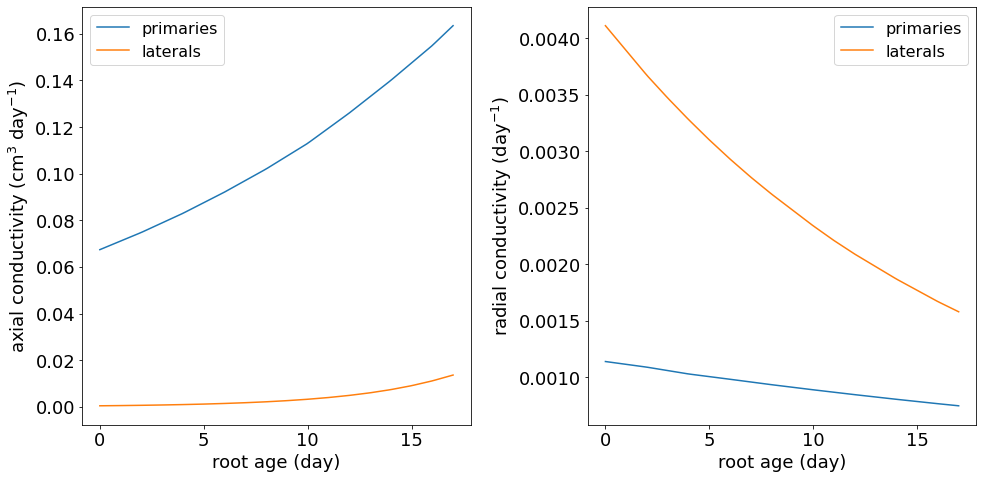

In [6]:
from scipy import interpolate
kx0 = np.array([[32,3.57E-01],[30,3.21E-01],[28,2.90E-01],[26,2.61E-01],[24,2.35E-01],[22,2.12E-01],[20,1.91E-01],
                [18,1.72E-01],[16,1.55E-01],[14,1.40E-01],[12,1.26E-01],[10,1.13E-01],[8,1.02E-01],[6,9.21E-02], 
                [4,8.30E-02],[2,7.48E-02],[0,6.74E-02]])
kr0 = np.array([[32,5.17E-04],[30,5.43E-04],[28,5.70E-04],[26,5.99E-04],[24,6.30E-04],[22,6.62E-04],[20,6.95E-04],
                [18,7.30E-04],[16,7.67E-04],[14,8.06E-04],[12,8.47E-04],[10,8.90E-04],[8,9.35E-04],[6,9.83E-04],
                [4,1.03E-03],[2,1.09E-03],[0,1.14E-03]])
kx1 = np.array([[17,1.36E-02],[16,1.11E-02],[15,9.03E-03],[14,7.34E-03],[13,5.97E-03],[12,4.86E-03],[11,3.95E-03],
                [10,3.21E-03],[9,2.61E-03],[8,2.12E-03],[7,1.73E-03],[6,1.41E-03],[5,1.14E-03],[4,9.30E-04],
                [3,7.56E-04],[2,6.15E-04],[1,5.00E-04],[0,4.07E-04]])
kr1 = np.array([[17,1.58E-03],[16,1.67E-03],[15,1.77E-03],[14,1.87E-03],[13,1.98E-03],[12,2.09E-03],[11,2.21E-03],
                [10,2.34E-03],[9,2.48E-03],[8,2.62E-03],[7,2.77E-03],[6,2.93E-03],[5,3.10E-03],[4,3.28E-03],
                [3,3.47E-03],[2,3.67E-03],[1,3.89E-03],[0,4.11E-03]])
kx0_ = interpolate.interp1d(kx0[:,0], kx0[:,1])
kr0_ = interpolate.interp1d(kr0[:,0], kr0[:,1])
kx1_ = interpolate.interp1d(kx1[:,0], kx1[:,1], fill_value = 1.36E-02, bounds_error = False)
kr1_ = interpolate.interp1d(kr1[:,0], kr1[:,1], fill_value = 1.58E-03, bounds_error = False)

# Plot function 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
age_ = np.linspace(0,17,100)
ax1.plot(age_,kx0_(age_), color = col[0], linewidth = 1.5, alpha = 1)
ax1.plot(age_,kx1_(age_), color = col[1], linewidth = 1.5, alpha = 1)
ax1.set_xlabel("root age (day)")
ax1.set_ylabel("axial conductivity (cm$^3$ day$^{-1}$)")
ax1.legend(["primaries", "laterals"])
ax2.plot(age_,kr0_(age_), color = col[0], linewidth = 1.5, alpha = 1)
ax2.plot(age_,kr1_(age_), color = col[1], linewidth = 1.5, alpha = 1)
ax2.set_ylabel("radial conductivity (day$^{-1}$)")
ax2.set_xlabel("root age (day)")
ax2.legend(["primaries", "laterals"])

fig.tight_layout()
plt.savefig('conductivities.png', dpi=300, bbox_inches = "tight")
plt.show()

## Reference solution

The hybrid analytical solution of Meunier et al. (2017) offers an exact solution to the benchmark. This method is implemented in CPlantBox and is used as reference solution. In this approach the segment age equals the node emergence time of the second node (for age dependent conductivites in M3.2b).

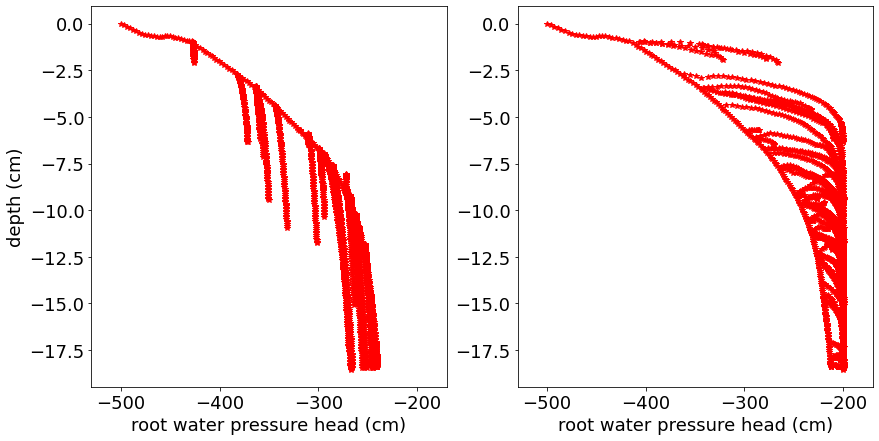

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14,7)) 

data = np.loadtxt("M3.2a Numerical results/Reference",delimiter=',') # M32a        
pl, = ax[0].plot(data[1,:],data[0,:],'r*')
ax[0].set_xlabel("root water pressure head (cm)")  
ax[0].set_ylabel("depth (cm)")  
ax[0].set_xlim(-530,-170)

data = np.loadtxt("M3.2b Numerical results/Reference",delimiter=',') # M32b       
pl, = ax[1].plot(data[1,:],data[0,:],'r*')
ax[1].set_xlabel("root water pressure head (cm)")   
ax[1].set_xlim(-530,-170)

plt.savefig('m32.png', dpi=300, bbox_inches = "tight")
plt.show() 

## References

Doussan, C., Pierret, A., Garrigues, E., and Pages, L. (2006). Water uptake by plant roots: II - Modelling of water transfer in the soil root-system with explicit account of flow within the root system - comparison with experiments. *Plant and Soil*, 283(1-2):99–117.

Roose, T. and Fowler, A. C. (2004). A model for water uptake by plant roots. *Journal of Theoretical Biology*, 228(2):155–171.

Schnepf, A., Leitner, D., Landl, M., Lobet, G., Mai, T.H., Morandage S., Sheng, C., Zoerner, M., Vanderborght, J., Vereecken, H. (2018) CRootBox: a structural-functional modelling framework for root systems. *Annals of Botany*, 121 (5), 1033-1053

Meunier F., Draye X., Vanderborght J., Javaux M., Couvreur V. (2017) A hybrid analytical-numerical method for solving water flow equations in root hydraulic architectures *Applied Mathematical modelling*